# Project Plan: Euro to USD Trend Analysis & Forecasting
### This script implements a project plan to analyze and forecast the Euro to USD exchange rate.
### It is divided into four main phases: Data Cleaning, Exploratory Data Analysis (EDA),
### Time Series Forecasting, and Volatility Analysis.

## Phase 1: Data Cleaning & Preparation

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("Phase 1: Starting Data Cleaning & Preparation...")

# Load the dataset
try:
    df = pd.read_csv(r"C:\Users\jpran\Downloads\EuroCR.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'EuroCR.csv' not found. Please ensure the file is in the same directory.")
    exit()

# Display the first few rows and column names to inspect the data
print("\nInitial data head:")
print(df.head())
print("\nInitial columns:")
print(df.columns.tolist())

# 1. Parse dates and rename the date column
df.rename(columns={'Period\\Unit:': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

# 2. Clean up column names by removing brackets and spaces
df.columns = df.columns.str.replace(r'[\[\] ]', '', regex=True)

# 3. Focus on relevant columns: US dollar, UK pound sterling, Indian rupee
relevant_cols = ['Date', 'USdollar', 'UKpoundsterling', 'Indianrupee']
currency_df = df[relevant_cols].copy()

# Set 'Date' as index
currency_df.set_index('Date', inplace=True)

# 4. Remove or fill NaNs. We will use forward-fill (ffill) to handle missing values
currency_df.replace('N/A', np.nan, inplace=True)
currency_df.ffill(inplace=True)
currency_df.bfill(inplace=True)

# Convert columns to numeric, coercing errors will turn non-numeric values to NaN
for col in currency_df.columns:
    currency_df[col] = pd.to_numeric(currency_df[col], errors='coerce')

# Drop any remaining NaNs in the US dollar column
currency_df.dropna(subset=['USdollar'], inplace=True)

# Display the cleaned data info
print("\nCleaned data info:")
print(currency_df.info())
print("\nCleaned data head:")
print(currency_df.head())

Phase 1: Starting Data Cleaning & Preparation...
Data loaded successfully.

Initial data head:
  Period\Unit: [Australian dollar ] [Bulgarian lev ] [Brazilian real ]  \
0   2023-01-27               1.5289           1.9558            5.5104   
1   2023-01-26               1.5308           1.9558            5.5572   
2   2023-01-25               1.5360           1.9558            5.5690   
3   2023-01-24               1.5470           1.9558            5.6164   
4   2023-01-23               1.5529           1.9558            5.6372   

  [Canadian dollar ] [Swiss franc ] [Chinese yuan renminbi ] [Cypriot pound ]  \
0             1.4479         1.0017                   7.3690              NaN   
1             1.4568         1.0002                   7.3893              NaN   
2             1.4544         1.0020                   7.3778              NaN   
3             1.4517         1.0053                   7.3642              NaN   
4             1.4523         1.0013                   7

## Phase 2: Exploratory Data Analysis (EDA)

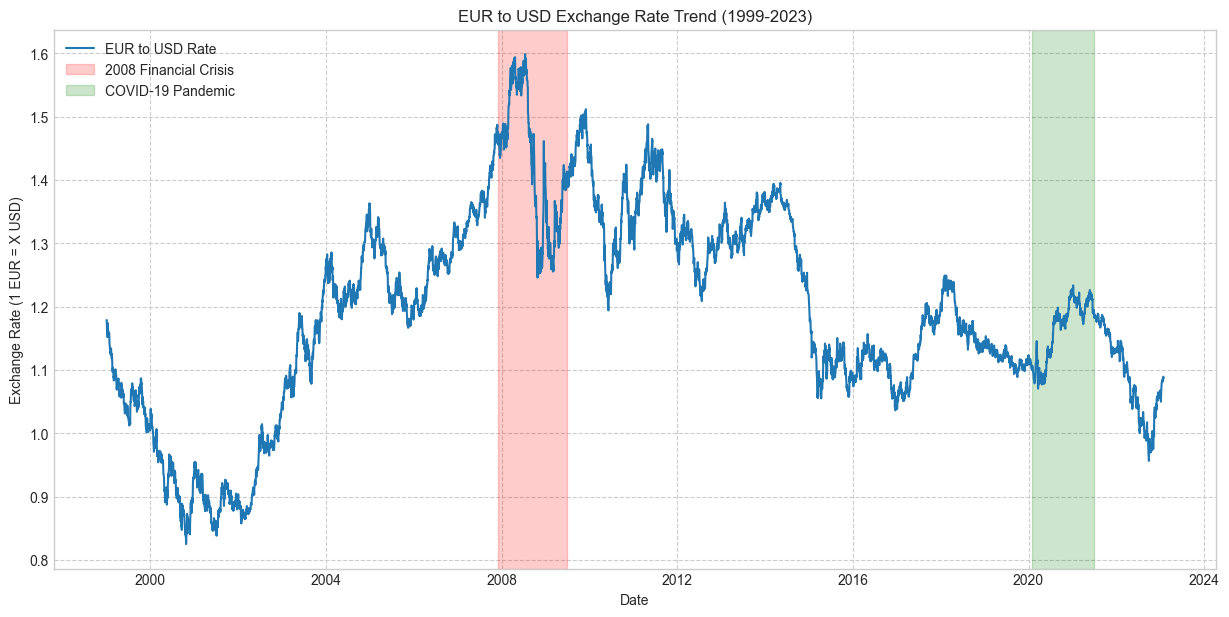

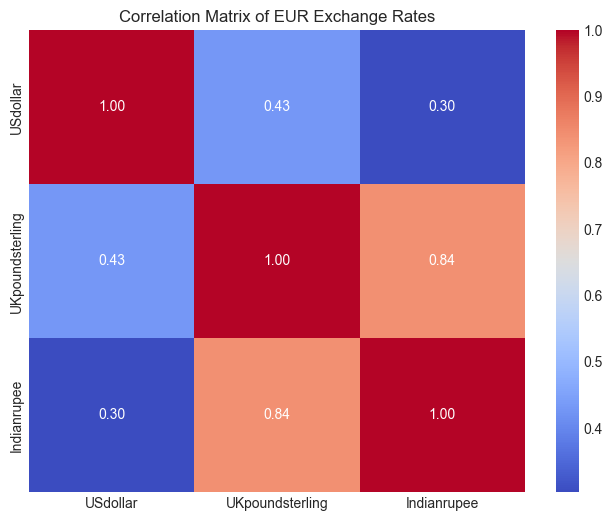

In [3]:
# Plot the EUR to USD trend over time
plt.figure(figsize=(15, 7))
plt.plot(currency_df.index, currency_df['USdollar'], label='EUR to USD Rate')
plt.title('EUR to USD Exchange Rate Trend (1999-2023)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (1 EUR = X USD)')
plt.grid(True, which='both', linestyle='--')

# Highlight key economic periods
# 2008 Financial Crisis (approximately late 2007 to mid-2009)
plt.axvspan(pd.to_datetime('2007-12-01'), pd.to_datetime('2009-06-30'), color='red', alpha=0.2, label='2008 Financial Crisis')
# COVID-19 Pandemic (approximately early 2020 to mid-2021)
plt.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2021-06-30'), color='green', alpha=0.2, label='COVID-19 Pandemic')

plt.legend()
plt.show()

# Plot the correlation matrix with the selected currencies
plt.figure(figsize=(8, 6))
corr_matrix = currency_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of EUR Exchange Rates')
plt.show()

## Phase 3: Time Series Forecasting


Training set size: 6077
Testing set size: 90

Fitting SARIMAX(1, 1, 1) model. This may take a moment...

SARIMAX model summary:
                               SARIMAX Results                                
Dep. Variable:               USdollar   No. Observations:                 6077
Model:               SARIMAX(1, 1, 1)   Log Likelihood               21370.597
Date:                Sat, 02 Aug 2025   AIC                         -42735.194
Time:                        11:02:09   BIC                         -42715.059
Sample:                             0   HQIC                        -42728.206
                               - 6077                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5518      1.752     -0.315      0.753      -3.985       2.882
ma

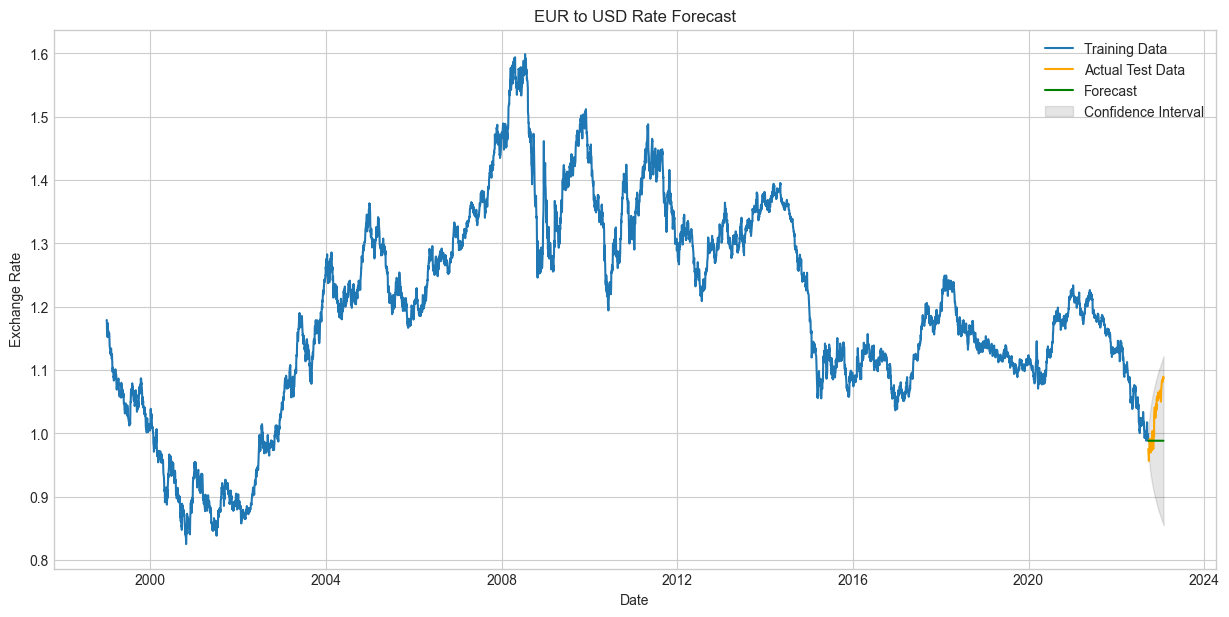


RMSE (Root Mean Squared Error): 0.0576
MAE (Mean Absolute Error): 0.0477


In [6]:
# Ensure the data is sorted in ascending order by date (oldest to newest)
currency_df_sorted = currency_df.sort_index()

# Split the data into training and testing sets
train_size = len(currency_df_sorted) - 90  # Use the last 90 days for testing
train, test = currency_df_sorted[:train_size], currency_df_sorted[train_size:]

print(f"\nTraining set size: {len(train)}")
print(f"Testing set size: {len(test)}")

# Use a standard SARIMAX model from statsmodels
# We'll use a simple (1, 1, 1) order as a reasonable starting point for non-seasonal data.
print("\nFitting SARIMAX(1, 1, 1) model. This may take a moment...")
sarimax_model = SARIMAX(train['USdollar'], order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
result = sarimax_model.fit(disp=False)

print("\nSARIMAX model summary:")
print(result.summary())

# Forecast for the next 90 days (the test set length)
forecast_result = result.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
# Align forecast and test indices to avoid NaN issues
forecast = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1].values, index=test.index)

# Remove any NaN values that may still exist (shouldn't be any, but just in case)
valid_idx = (~forecast.isna()) & (~test['USdollar'].isna())
forecast_valid = forecast[valid_idx]
test_valid = test['USdollar'][valid_idx]
lower_valid = lower_series[valid_idx]
upper_valid = upper_series[valid_idx]

# Plot the forecast
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['USdollar'], label='Training Data')
plt.plot(test_valid.index, test_valid, label='Actual Test Data', color='orange')
plt.plot(forecast_valid.index, forecast_valid, label='Forecast', color='green')
plt.fill_between(lower_valid.index, lower_valid, upper_valid, color='k', alpha=0.1, label='Confidence Interval')
plt.title('EUR to USD Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Evaluate the forecast using RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_valid, forecast_valid))
mae = mean_absolute_error(test_valid, forecast_valid)

print(f"\nRMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")

## Phase 4: Volatility Analysis

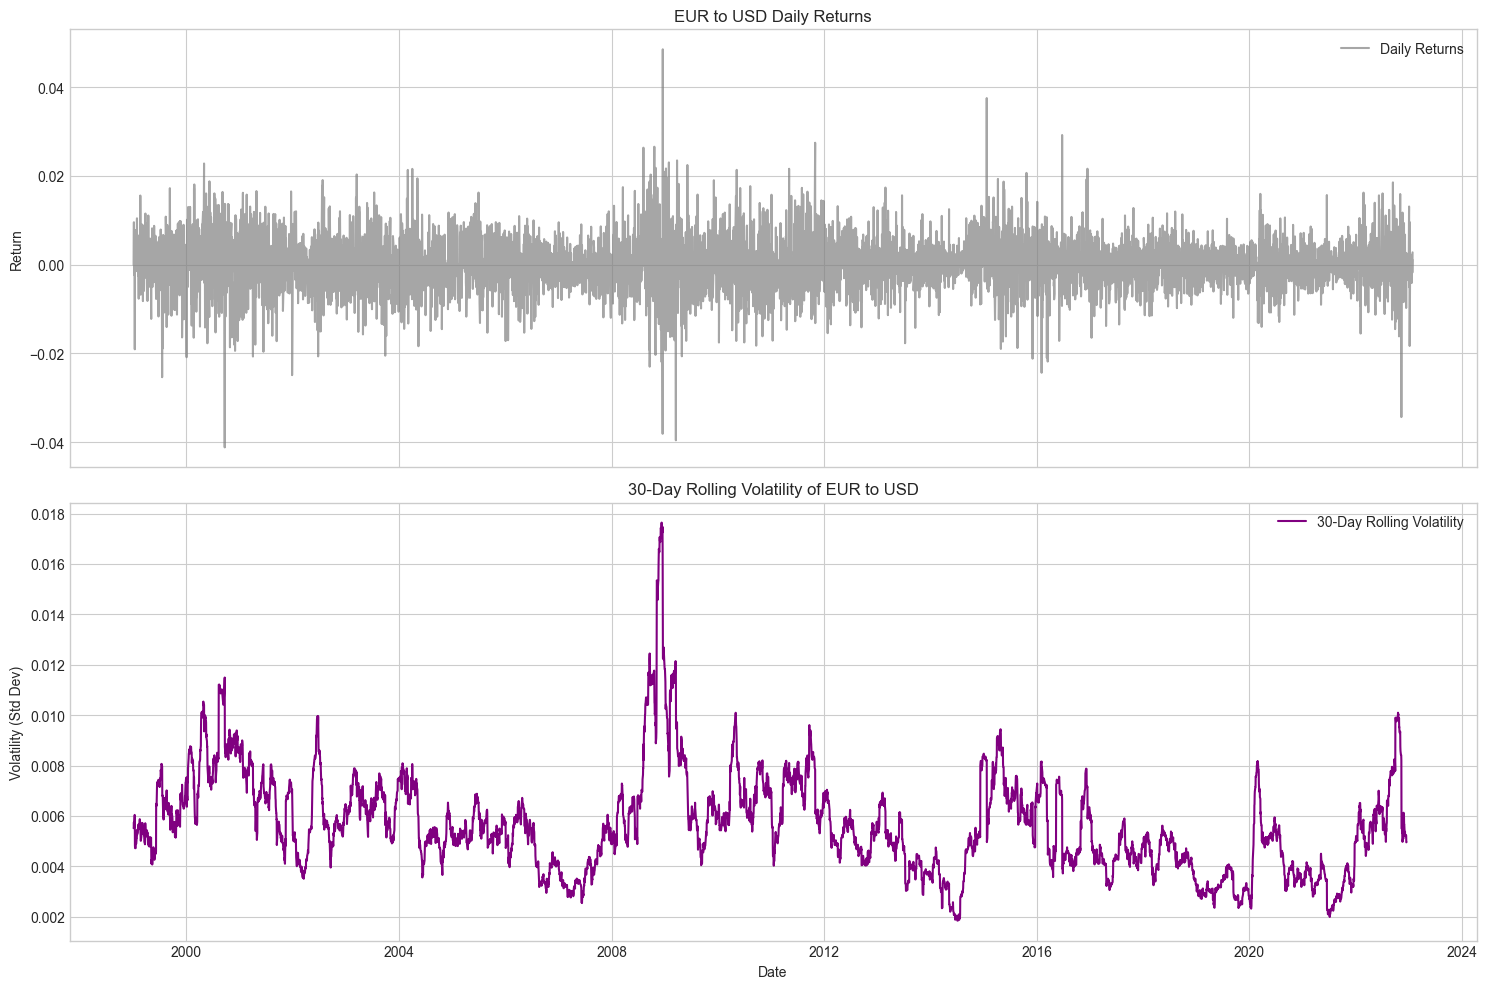

In [7]:
# Calculate daily returns for the EUR to USD rate
returns = currency_df['USdollar'].pct_change().dropna()

# Calculate rolling standard deviation (volatility) over a 30-day window
volatility = returns.rolling(window=30).std()

# Plot daily returns and rolling volatility
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axes[0].plot(returns.index, returns, label='Daily Returns', color='gray', alpha=0.7)
axes[0].set_title('EUR to USD Daily Returns')
axes[0].set_ylabel('Return')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(volatility.index, volatility, label='30-Day Rolling Volatility', color='purple')
axes[1].set_title('30-Day Rolling Volatility of EUR to USD')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volatility (Std Dev)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()